In [1]:
import os
import shutil
import uuid
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

/home/faird/mdemiden/miniconda3/envs/fmri_env/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


# e-prime .txt raw --> .csv
The e-prime headers differ between subjects. Importing _EventsRelatedInformation.txt_ into pandas dataframes as they are downloaded from NDA is not feasible. Thus, using [abcc_datapre](https://github.com/demidenm/abcc_datapre) read-in code to populate and resafe files.

First define the initial functions that are used to read files, etc, in the case of the events related files. note, both runs are within the same file

In [2]:
# Using Taylor Taslo's script convert txt to df code from github: tsalo/convert-eprime/ as could not use from package.
# Credit for lines #36 to #93 should be given to Taylor.
def remove_unicode(string):
    """
    Removes unicode characters in string.
    """
    return ''.join([val for val in string if 31 < ord(val) < 127])


def text_to_df(text_file):
    """
    Convert a raw E-Prime output text file into a pandas DataFrame.
    """
    # Load the text file as a list.
    with open(text_file, 'rb') as fo:
        text_data = list(fo)

    # Remove unicode characters.
    filtered_data = [remove_unicode(row.decode('utf-8', 'ignore')) for row in text_data]

    # Determine where rows begin and end.
    start_index = [i for i, row in enumerate(filtered_data) if row == '*** LogFrame Start ***']
    end_index = [i for i, row in enumerate(filtered_data) if row == '*** LogFrame End ***']
    if len(start_index) != len(end_index) or start_index[0] >= end_index[0]:
        print('Warning: LogFrame Starts and Ends do not match up.',
              'Including header metadata just in case.')
        # In cases of an experiment crash, the final LogFrame is never written, and the experiment metadata
        # (Subject, VersionNumber, etc.) isn't collected by the indices above. We can manually include the
        # metadata-containing Header Frame to collect these data from a partial-run crash dump.
        start_index = [i for i, row in enumerate(filtered_data) if row == '*** Header Start ***'] + start_index
        end_index = [i for i, row in enumerate(filtered_data) if row == '*** Header End ***'] + end_index
    n_rows = min(len(start_index), len(end_index))

    # Find column headers and remove duplicates.
    headers = []
    data_by_rows = []
    for i in range(n_rows):
        one_row = filtered_data[start_index[i]+1:end_index[i]]
        data_by_rows.append(one_row)
        for col_val in one_row:
            split_header_idx = col_val.index(':')
            headers.append(col_val[:split_header_idx])

    headers = list(OrderedDict.fromkeys(headers))

    # Preallocate list of lists composed of NaNs.
    data_matrix = np.empty((n_rows, len(headers)), dtype=object)
    data_matrix[:] = np.nan

    # Fill list of lists with relevant data from data_by_rows and headers.
    for i in range(n_rows):
        for cell_data in data_by_rows[i]:
            split_header_idx = cell_data.index(':')
            for k_header, header in enumerate(headers):
                if cell_data[:split_header_idx] == header:
                    data_matrix[i, k_header] = cell_data[split_header_idx+1:].lstrip()

    df = pd.DataFrame(columns=headers, data=data_matrix)

    # Columns with one value at the beginning, the end, or end - 1 should be
    # filled with that value.
    for col in df.columns:
        non_nan_idx = np.where(df[col].values == df[col].values)[0]
        if len(non_nan_idx) == 1 and non_nan_idx[0] in [0, df.shape[0]-1,
                                                        df.shape[0]-2]:
            df.loc[:, col] = df.loc[non_nan_idx[0], col]
    return df

Running the data load and conversion to .tsv for each subject. Set directories, loop over list of files.

In [25]:
eprime_raw = '/home/feczk001/mdemiden/analyses/rt_plumbing/eprime_raw/'
eprime_tsv = '/home/feczk001/mdemiden/analyses/rt_plumbing/eprime_raw_tsv/'

In [26]:
eprime_raw_list = os.listdir(eprime_raw)

In [27]:
for filepath in eprime_raw_list:
    eprime_out_name = os.path.splitext(filepath)[0] + '.tsv'
    filepath = eprime_raw + filepath
    if not os.path.exists(file_path):
        # some files are written in utf-16 as opposed to most using uts-8. Using try and except rule to circumvent errors
        # this, too, applies to checking the type of edge case errors when reading in files.
        try:
            try:
                dat = pd.read_csv(filepath, nrows=3)
                open_type = "csv:skip3rows"
            except pd.errors.ParserError:
                dat = pd.read_csv(filepath, nrows=1)
                open_type = "csv:skip1row"
        
            # check for edat2 in row 1
            if ".edat2" in dat.columns[0]:
                # check for 2nd row with edited data.. remove if label exist need to remove redudant rows
                if "edited data" in dat.iloc[0, 0]:
                    dat = pd.read_csv(filepath, skiprows=2, sep="\t")
                    open_type = "edat2:edited-skip2rows"
        
                else:
                    dat = pd.read_csv(filepath, skiprows=1, sep="\t")
                    open_type = "edat2:skip1row"
        
            elif "Header Start" in dat.columns[0]:
                dat = text_to_df(filepath)
                open_type = "eprimetxt:HeaderStart"
            else:
                dat = pd.read_csv(filepath, sep="\t")
                open_type = "csv:simple"
        
        # If UTF-8 encoding fails, try reading the file with UTF-16 encoding
        except UnicodeDecodeError:
            try:
                dat = pd.read_csv(filepath, encoding='utf-16', nrows=3)
                open_type = "csv:skip3rows-utf16"
            except pd.errors.ParserError:
                dat = pd.read_csv(filepath, encoding='utf-16', nrows=1)
                open_type = "csv:skip1row-utf16"
            # Chech for .edat2 in row1
            if ".edat2" in dat.columns[0]:
                if "edited data" in dat.iloc[0, 0]:
                    dat = pd.read_csv(filepath, encoding='utf-16', skiprows=2, sep="\t")
                    open_type = "edat2:edited-skip2rows-utf16"
                else:
                    dat = pd.read_csv(filepath, encoding='utf-16', skiprows=1, sep="\t")
                    open_type = "edat2:edited-skip1row-utf16"
            elif "Header Start" in dat.columns[0]:
                dat = text_to_df(filepath)
                open_type = "eprimetxt:HeaderStart-utf16"
        
            else:
                dat = pd.read_csv(filepath, encoding='utf-16', sep="\t")
                open_type = "csv:simple-utf16"
        
        # assigned subdject ID column from NARGUID
        dat['Subject'] = dat['NARGUID']
        dat.to_csv(os.path.join(eprime_tsv, eprime_out_name), 
                   sep='\t', index=False)


In [29]:
eprime_tsv_list = os.listdir(eprime_tsv)
len(eprime_tsv_list)

500

# Check eprime header cols and rows for single subject

In [30]:
sub1_etsv = pd.read_csv(os.path.join(eprime_tsv, eprime_tsv_list[0]), sep = '\t')

In [35]:
sub1_etsv.columns.tolist()

['ExperimentName',
 'Subject',
 'Session',
 'Allowed',
 'Clock.Information',
 'DataFile.Basename',
 'Display.RefreshRate',
 'ExperimentVersion',
 'Group',
 'Handedness',
 'NARGUID',
 'PracticeRT',
 'RandomSeed',
 'RuntimeCapabilities',
 'RuntimeVersion',
 'RuntimeVersionExpected',
 'SessionDate',
 'SessionStartDateTimeUtc',
 'SessionTime',
 'StudioVersion',
 'TrialOrder',
 'triggercode',
 'Block',
 'BlockList',
 'BlockList.Cycle',
 'BlockList.Sample',
 'BlockTitle',
 'EndFix.Duration',
 'EndFix.DurationError',
 'EndFix.FinishTime',
 'EndFix.OffsetDelay',
 'EndFix.OffsetTime',
 'EndFix.OnsetDelay',
 'EndFix.OnsetTime',
 'EndFix.OnsetToOnsetTime',
 'EndFix.StartTime',
 'Procedure[Block]',
 'Running[Block]',
 'Trial',
 'GetReady.RTTime',
 'PeriodList',
 'PeriodList.Cycle',
 'PeriodList.Sample',
 'PrepTime.Duration',
 'PrepTime.DurationError',
 'PrepTime.FinishTime',
 'PrepTime.OffsetDelay',
 'PrepTime.OffsetTime',
 'PrepTime.OnsetDelay',
 'PrepTime.OnsetTime',
 'PrepTime.OnsetToOnsetTime'

In [42]:
for 
    sub1_etsv = pd.read_csv(os.path.join(eprime_tsv, eprime_tsv_list[0]), sep = '\t')
    sub1_etsv = sub1_etsv.dropna(subset=['Condition'])


100

TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'

## Jeanettes Plotting Code

In [46]:
# Trial counts by condition (within-run)
# Average RTs by condition (within-run)
# RT missingness by condition (within-run)
# Whether the button press is during probe or feedback
def pull_rt_info(event_files, time_multiple=None, eprime=False):
    response_types = ['Correct Response!', 'You pressed too slow!', 'You pressed too soon!']
    rt_missing = [True, False]
    measure_types = ['mean_rt', 'trial_count', 'percent_missing_rt', 'count_button_press_during_feedback', 'mean_button_press_relative_to_fb_onset_press_during_feedback']
    
    output = {measure:[] for measure in measure_types}
    output['response_type'] = []
    output['rt_missing'] = []
    
    output_all_button_press_relative_to_fb_onset = {f'{response_type}:rt_missing_{rt_missing_val}': [] for response_type in response_types for rt_missing_val in rt_missing}

    for ind, event_file in enumerate(event_files):
        df = pd.read_csv(event_file, sep = '\t')
        
        if eprime == True:
            df = df.dropna(subset=['Condition'])
            
        if time_multiple is None:
            df['button_press_during_feedback'] = df['Probe.OnsetTime'] + df['OverallRT'] > df['Feedback.OnsetTime']
            df['button_press_relative_to_fb_onset'] = df['Feedback.OnsetTime'] - (df['Probe.OnsetTime'] + df['OverallRT'])
        else:
            df['button_press_during_feedback'] = df['Probe.OnsetTime']*time_multiple + df['OverallRT'] > df['Feedback.OnsetTime']*time_multiple
            df['button_press_relative_to_fb_onset'] = df['Feedback.OnsetTime']*time_multiple - (df['Probe.OnsetTime']*time_multiple + df['OverallRT'])

        for response_type in response_types:
            for rt_missing_val in rt_missing:
                output['response_type'].append(response_type)
                output['rt_missing'].append(rt_missing_val)
                output['mean_rt'].append(
                    df[(df['ResponseCheck']==response_type) & (df['OverallRT'].isnull()==rt_missing_val)]['OverallRT'].mean()
                )
                output['trial_count'].append(
                    df[(df['ResponseCheck']==response_type) & (df['OverallRT'].isnull()==rt_missing_val)].shape[0]
                )
                if (df[df['ResponseCheck']==response_type].shape[0] > 0) and rt_missing_val==True:
                    output['percent_missing_rt'].append(
                        df[(df['ResponseCheck']==response_type) & (df['OverallRT'].isnull()==rt_missing_val)].shape[0] / df[df['ResponseCheck']==response_type].shape[0]
                    )
                else:
                    output['percent_missing_rt'].append(np.nan)
                output['count_button_press_during_feedback'].append(
                    df[(df['ResponseCheck']==response_type) & (df['OverallRT'].isnull()==rt_missing_val)]['button_press_during_feedback'].sum()
                )
                output['mean_button_press_relative_to_fb_onset_press_during_feedback'].append(
                    df[(df['ResponseCheck']==response_type) & (df['OverallRT'].isnull()==rt_missing_val) & (df['button_press_during_feedback']==True)]['button_press_relative_to_fb_onset'].mean()
                )
                output_all_button_press_relative_to_fb_onset[f'{response_type}:rt_missing_{rt_missing_val}'].extend(
                    df[(df['ResponseCheck']==response_type) & (df['OverallRT'].isnull()==rt_missing_val)]['button_press_relative_to_fb_onset'].tolist()
                )
    return pd.DataFrame(output), output_all_button_press_relative_to_fb_onset

In [49]:
eprime_event_files = glob(f'{eprime_tsv}/*.tsv')
len(eprime_event_files)

500

In [50]:
output_df, output_button_press_all_trials = pull_rt_info(eprime_event_files, time_multiple=None, eprime=True)

## How are trials splits between missing/not missing RT and response types (as measured by counts wtihin a run)?


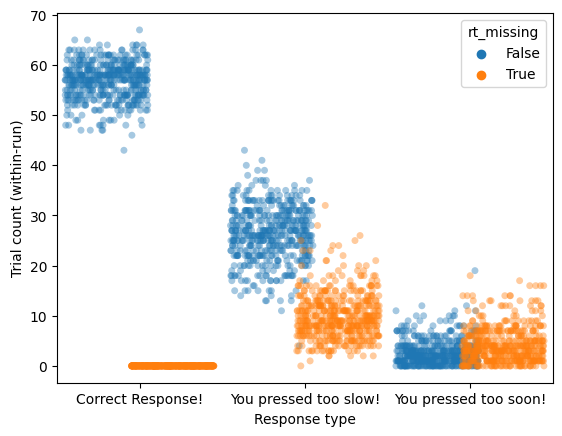

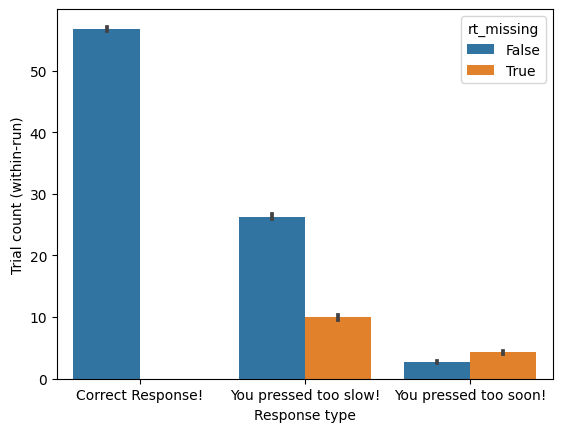

In [51]:
g = sns.stripplot(data=output_df, x='response_type', y='trial_count', hue='rt_missing', dodge=True, alpha=.4, jitter=.5)
g.set_ylabel('Trial count (within-run)')
g.set_xlabel('Response type')
plt.show()

g = sns.barplot(data=output_df, x='response_type', y='trial_count', hue='rt_missing')
g.set_ylabel('Trial count (within-run)')
g.set_xlabel('Response type')
plt.show()

## What percentage of trials, within each response type, are missing RTs?


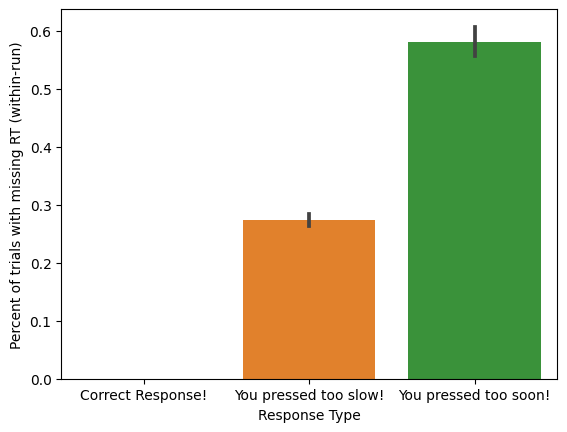

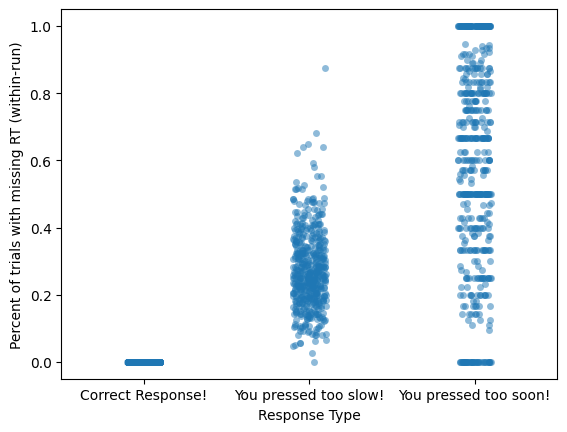

In [52]:
g = sns.barplot(data=output_df[output_df['rt_missing']==True], x='response_type', y='percent_missing_rt')
g.set_ylabel('Percent of trials with missing RT (within-run)')
g.set_xlabel('Response Type')
plt.show()


g = sns.stripplot(data=output_df[output_df['rt_missing']==True], x='response_type', y='percent_missing_rt', jitter=True, alpha=0.5)
g.set_ylabel('Percent of trials with missing RT (within-run)')
g.set_xlabel('Response Type')
plt.show()

## What do RTs look like when they are recorded?

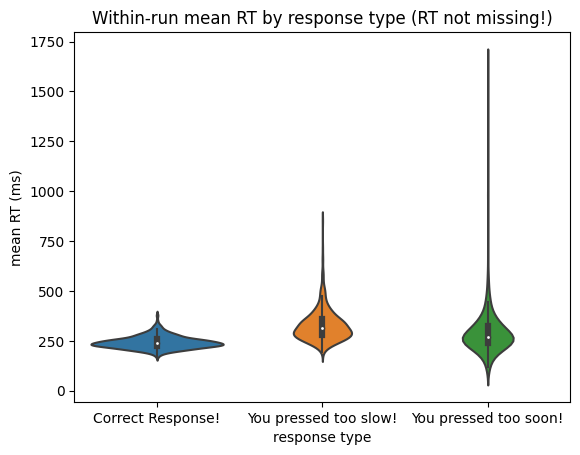

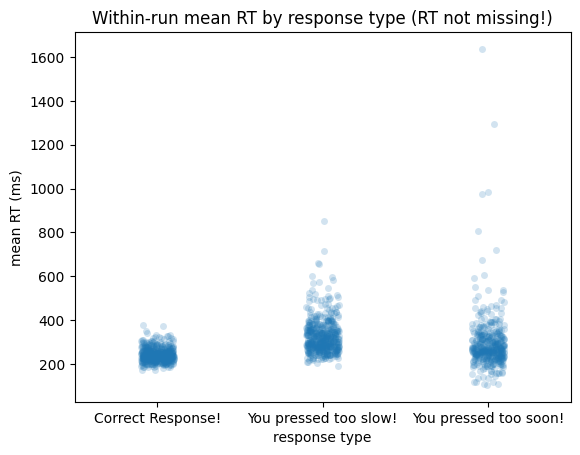

In [53]:
g = sns.violinplot(data=output_df[output_df['rt_missing']==False], x='response_type', y='mean_rt')
g.set_ylabel('mean RT (ms)')
g.set_xlabel('response type')
g.set_title('Within-run mean RT by response type (RT not missing!)')
plt.show()

g = sns.stripplot(data=output_df[output_df['rt_missing']==False], x='response_type', y='mean_rt', alpha=.2, jitter=True)
g.set_ylabel('mean RT (ms)')
g.set_xlabel('response type')
g.set_title('Within-run mean RT by response type (RT not missing!)')
plt.show()

## How often does a button press occur during the feedback phase?

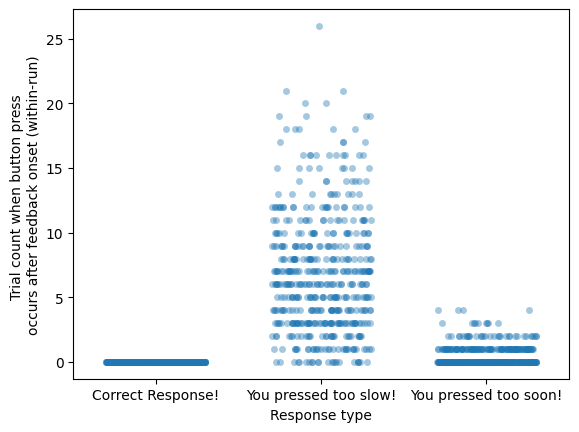

In [54]:
g = sns.stripplot(data=output_df[output_df['rt_missing']==False], x='response_type', y='count_button_press_during_feedback', alpha=.4, jitter=.3)
g.set_ylabel('Trial count when button press \noccurs after feedback onset (within-run)')
g.set_xlabel('Response type')
plt.show()

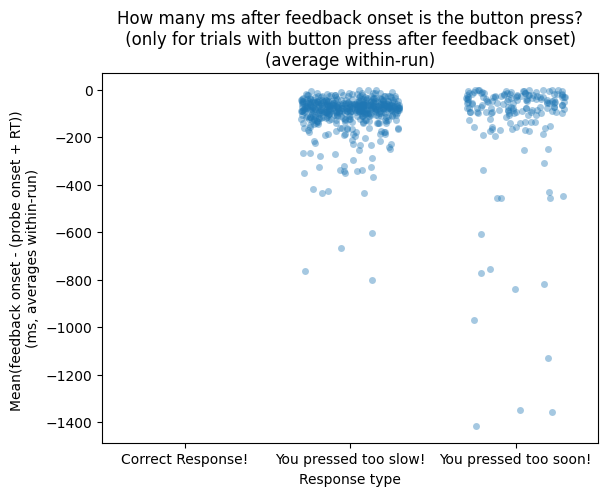

/home/faird/mdemiden/miniconda3/envs/fmri_env/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/faird/mdemiden/miniconda3/envs/fmri_env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,


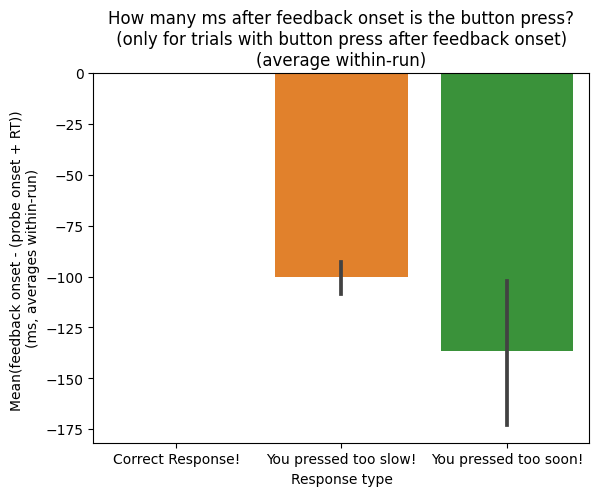

In [55]:
g = sns.stripplot(data=output_df[output_df['rt_missing']==False], x='response_type', y='mean_button_press_relative_to_fb_onset_press_during_feedback',
                   alpha=.4, jitter=.3)
g.set_ylabel('Mean(feedback onset - (probe onset + RT)) \n(ms, averages within-run)')
g.set_xlabel('Response type')
g.set_title('How many ms after feedback onset is the button press?\n (only for trials with button press after feedback onset) \n(average within-run)')
plt.show()

g = sns.barplot(data=output_df[output_df['rt_missing']==False], x='response_type', y='mean_button_press_relative_to_fb_onset_press_during_feedback')
g.set_ylabel('Mean(feedback onset - (probe onset + RT)) \n(ms, averages within-run)')
g.set_xlabel('Response type')
g.set_title('How many ms after feedback onset is the button press?\n (only for trials with button press after feedback onset) \n(average within-run)')
plt.show()

## Difference between feedback - (probe + rt) for all trials (not averaged within-run)


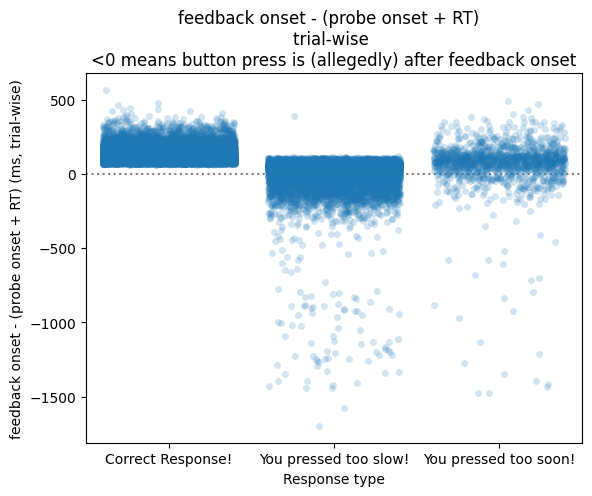

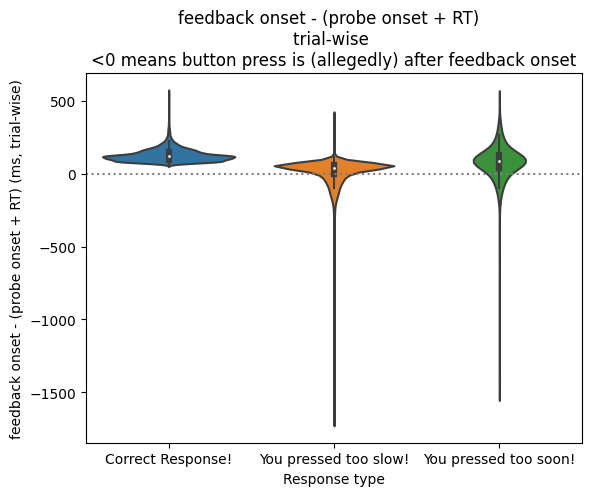

In [56]:
diffs = output_button_press_all_trials['Correct Response!:rt_missing_False'] + \
         output_button_press_all_trials['You pressed too slow!:rt_missing_False'] +\
         output_button_press_all_trials['You pressed too soon!:rt_missing_False']
labels = ['Correct Response!'] * len(output_button_press_all_trials['Correct Response!:rt_missing_False']) +\
          ['You pressed too slow!'] * len(output_button_press_all_trials['You pressed too slow!:rt_missing_False']) +\
          ['You pressed too soon!'] * len(output_button_press_all_trials['You pressed too soon!:rt_missing_False'])

dat_plot = pd.DataFrame({'diffs': diffs,
                         'labels': labels})

g = sns.stripplot(data=dat_plot, x='labels', y='diffs', alpha=.2, jitter=.4)
g.axhline(0, color='gray', linestyle=':')
g.set_ylabel('feedback onset - (probe onset + RT) (ms, trial-wise)')
g.set_xlabel('Response type')
g.set_title('feedback onset - (probe onset + RT)  \ntrial-wise \n<0 means button press is (allegedly) after feedback onset')
plt.show()

g = sns.violinplot(data=dat_plot, x='labels', y='diffs')
g.axhline(0, color='gray', linestyle=':')
g.set_ylabel('feedback onset - (probe onset + RT) (ms, trial-wise)')
g.set_xlabel('Response type')
g.set_title('feedback onset - (probe onset + RT)  \ntrial-wise \n<0 means button press is (allegedly) after feedback onset')
plt.show()